# Trying BarlowTwins on CIFAR-10

In [1]:
from os import makedirs

import torch
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

from torchvision.models import resnet18

from models import BarlowTwins
#from optimizer import LARS
from trainer import SSL_Trainer
from utils import SSL_CIFAR10

# Define hyperparameters
#data_root = '/home/space/datasets/'
data_root = '/home/fcfschulz/Documents/workspace/data/Vision/'
save_root = './results/barlow_twins/'

dl_kwargs = {'batch_size': 512, 'shuffle': True, 'num_workers': 2}

# Define data
ssl_data = SSL_CIFAR10(data_root,'BYOL', dl_kwargs)

train_params = {'save_root': save_root, 'num_epochs': 10, 'optimizer': SGD,
                'scheduler': CosineAnnealingLR, 'warmup_epochs': 5, 'iter_scheduler':True,
                'evaluate_at': [100,200,400,600], 'verbose':True}

## In Original Paper for Imagenet when using LARS Optimizer
#optim_params = {'lr':0.2 * dl_kwargs['batch_size']/256, 'weight_decay': 1.5e-6,
#                'exclude_bias_and_norm': True}
optim_params = {'lr': 1e-3, 'momentum': 0.9, 'weight_decay': 5e-4} # from here: https://github.com/IgorSusmelj/barlowtwins/blob/main/main.py

scheduler_params = {'T_max': (train_params['num_epochs']-train_params['warmup_epochs'])*len(ssl_data.train_dl)}
                    # 'eta_min': 1e-3} in orginal implementation

eval_params  = {'lr':1e-2, 'num_epochs': 25, 'milestones': [12,20]}

# Get device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Print Device Type
if torch.cuda.is_available():
    print(f"Program running on {torch.cuda.get_device_name(device)}")
else:
    print("Program running on CPU")
    
# Create folder if it does not exists
makedirs(save_root, exist_ok=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Program running on CPU


# BarlowTwins

In [2]:
# Define Model
resnet = resnet18(zero_init_residual=True)

barlow_twins = BarlowTwins(resnet, projector_hidden = (2048,2048,2048)).to(device)

# Define Trainer
cifar10_trainer = SSL_Trainer(barlow_twins, ssl_data, device)

# Train
cifar10_trainer.train(**train_params, optim_params=optim_params,
                      scheduler_params=scheduler_params, eval_params=eval_params)


scheduler = warmup
epoch 0, Time epoch: 0.001992464065551758
epoch 1, Time epoch: 0.0010230541229248047
epoch 2, Time epoch: 0.0011229515075683594
epoch 3, Time epoch: 0.0023794174194335938
epoch 4, Time epoch: 0.0011363029479980469
epoch 5, Time epoch: 0.0011858940124511719
epoch 6, Time epoch: 0.0011179447174072266
epoch 7, Time epoch: 0.0011334419250488281
epoch 8, Time epoch: 0.0011103153228759766
epoch 9, Time epoch: 0.0011439323425292969
epoch 10, Time epoch: 0.0012314319610595703
epoch 11, Time epoch: 0.0010972023010253906
epoch 12, Time epoch: 0.0011463165283203125
epoch 13, Time epoch: 0.0010890960693359375
epoch 14, Time epoch: 0.0010807514190673828
epoch 15, Time epoch: 0.001096487045288086
epoch 16, Time epoch: 0.026607275009155273
epoch 17, Time epoch: 0.0012218952178955078
epoch 18, Time epoch: 0.001123666763305664
epoch 19, Time epoch: 0.0010824203491210938
epoch 20, Time epoch: 0.001092672348022461
epoch 21, Time epoch: 0.0011365413665771484
epoch 22, Time epoch: 0.001

/home/fcfschulz/Programs/miniconda3/envs/playground/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


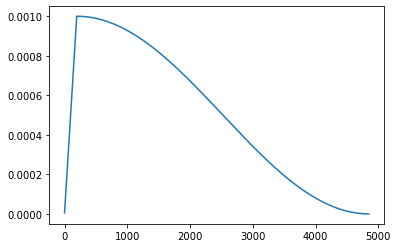

In [3]:
import matplotlib.pyplot as plt

plt.plot(cifar10_trainer._hist_lr);